In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
jobs = pd.read_csv('../data/fullsample.csv')
jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0


In [3]:
jobs.info

<bound method DataFrame.info of               JOBID      STATE                BEGIN                  END  \
0          30616928    RUNNING  2021-07-31T22:15:00              Unknown   
1          30853133  COMPLETED  2021-08-06T11:36:09  2021-09-05T11:36:32   
2          30858137  COMPLETED  2021-08-06T19:04:39  2021-09-05T19:04:53   
3          30935078  COMPLETED  2021-08-09T16:52:51  2021-09-07T20:52:55   
4        31364111_2  COMPLETED  2021-08-17T07:45:07  2021-09-10T16:45:24   
...             ...        ...                  ...                  ...   
7395880    25493434  COMPLETED  2020-10-31T23:39:00  2020-10-31T23:40:46   
7395881    25493435  COMPLETED  2020-10-31T23:39:13  2020-10-31T23:40:38   
7395882    25493476  COMPLETED  2020-10-31T23:46:29  2020-10-31T23:49:43   
7395883    25493515  COMPLETED  2020-10-31T23:49:44  2020-10-31T23:51:40   
7395884    25493542  COMPLETED  2020-10-31T23:56:49  2020-10-31T23:59:57   

           REQMEM    USEDMEM      REQTIME     USEDTIME 

In [4]:
jobs.columns

Index(['JOBID', 'STATE', 'BEGIN', 'END', 'REQMEM', 'USEDMEM', 'REQTIME',
       'USEDTIME', 'NODES', 'CPUS', 'PARTITION', 'EXITCODE'],
      dtype='object')

In [5]:
incomplete_jobs = jobs[(jobs['EXITCODE']!='0:0') | (jobs['STATE']!='COMPLETED')]
incomplete_jobs.sample(10)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
5874120,26143419_37,CANCELLED by 0,2020-12-02T17:56:45,2020-12-02T17:56:45,7168Mn,0,01:30:00,00:00:00,1,1,production,1:0
2524449,30456948,CANCELLED,2021-07-23T22:47:05,2021-07-23T22:47:28,4096Mn,0,00:20:00,00:00:23,1,1,production,0:0
3200580,29899834,CANCELLED,2021-06-25T15:52:10,2021-06-25T15:52:16,87040Mn,0,20:00:00,00:00:06,1,15,production,0:0
2893325,29591129,FAILED,2021-06-11T16:41:13,2021-06-12T01:14:30,12288Mc,5254.28M,3-00:00:00,08:33:17,4,64,production,121:0
2280549,30192308,CANCELLED,2021-07-09T17:48:33,2021-07-09T18:26:42,4096Mn,253.82M,1-16:00:00,00:38:09,1,12,production,0:11
5971902,26321692,CANCELLED by 9201,2020-12-08T14:20:22,2020-12-08T14:20:22,28000Mn,0,2-00:00:00,00:00:00,1,4,production,0:0
350412,32240197,FAILED,2021-09-12T11:24:41,2021-09-12T11:24:46,20000Mn,0,1-00:00:00,00:00:05,1,1,production,1:0
3411593,29023678,FAILED,2021-05-04T15:53:38,2021-05-04T15:59:18,24576Mn,164.63M,4-00:00:00,00:05:40,1,1,pascal,1:0
6522571,25938364,CANCELLED,2020-11-21T12:41:53,2020-11-21T12:41:57,28000Mn,0,2-00:00:00,00:00:04,1,4,production,0:0
6515492,25922093,CANCELLED by 9202,2020-11-20T10:58:51,2020-11-20T10:58:51,5000Mn,0,2-00:00:00,00:00:00,1,1,production,0:0


In [6]:
incomplete_jobs['STATE'].value_counts()

STATE
CANCELLED              9055
FAILED                 3766
CANCELLED by 9201      1776
OUT_OF_MEMORY          1739
CANCELLED by 776869     702
                       ... 
CANCELLED by 686562       1
CANCELLED by 891323       1
CANCELLED by 19853        1
CANCELLED by 494371       1
CANCELLED by 515423       1
Name: count, Length: 144, dtype: int64

In [7]:
from datetime import datetime

date_string = '0' #jobs['BEGIN'].iloc[0]

def try_parsing_date(text):
    for fmt in ("%Y-%m-%dT%H:%M:%S", "%Y-%m-%dT%H:%M:%S.%f"):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            return pd.NaT

date = try_parsing_date(date_string)
print(date)

NaT


In [8]:
jobs['BEGIN_dt'] = jobs['BEGIN'].apply(lambda x: try_parsing_date(x))
jobs.dtypes

JOBID                object
STATE                object
BEGIN                object
END                  object
REQMEM               object
USEDMEM              object
REQTIME              object
USEDTIME             object
NODES                 int64
CPUS                  int64
PARTITION            object
EXITCODE             object
BEGIN_dt     datetime64[ns]
dtype: object

In [9]:
jobs['END_dt'] = jobs['END'].apply(lambda x: try_parsing_date(x))
jobs.head(2)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,BEGIN_dt,END_dt
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0,2021-07-31 22:15:00,NaT
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0,2021-08-06 11:36:09,2021-09-05 11:36:32


In [10]:
jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,BEGIN_dt,END_dt
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0,2021-07-31 22:15:00,NaT
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0,2021-08-06 11:36:09,2021-09-05 11:36:32
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0,2021-08-06 19:04:39,2021-09-05 19:04:53
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0,2021-08-09 16:52:51,2021-09-07 20:52:55
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0,2021-08-17 07:45:07,2021-09-10 16:45:24


We want to look at '2020-11-27 12:40:27' specifically because there were 127 errors in this one second according to CE6

In [11]:
print(jobs['BEGIN_dt'].dtype)


datetime64[ns]


In [12]:
print(jobs['BEGIN_dt'].min(), jobs['BEGIN_dt'].max())


2020-10-01 00:03:08 2021-10-07 20:39:26


In [13]:
close_values = jobs.loc[jobs['BEGIN_dt'].between('2020-11-27 00:00:00', '2020-11-27 23:59:59')]
close_values.sort_values('BEGIN_dt')
#closer = close_values[close_values['STATE']!='COMPLETED']
#closer


,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,BEGIN_dt,END_dt
6593558,26051493,COMPLETED,2020-11-27T00:00:14,2020-11-27T15:54:54,5000Mn,2964M,2-00:00:00,15:54:40,1,1,production,0:0,2020-11-27 00:00:14,2020-11-27 15:54:54
6593622,26051569,COMPLETED,2020-11-27T00:01:13,2020-11-27T00:14:14,32768Mn,533.30M,01:00:00,00:13:01,1,2,production,0:0,2020-11-27 00:01:13,2020-11-27 00:14:14
6593619,26051566,COMPLETED,2020-11-27T00:01:13,2020-11-27T00:12:18,32768Mn,525.20M,01:00:00,00:11:05,1,2,production,0:0,2020-11-27 00:01:13,2020-11-27 00:12:18
6593618,26051565,COMPLETED,2020-11-27T00:01:13,2020-11-27T00:14:22,32768Mn,523.53M,01:00:00,00:13:09,1,2,production,0:0,2020-11-27 00:01:13,2020-11-27 00:14:22
6593617,26051564,COMPLETED,2020-11-27T00:01:13,2020-11-27T00:14:16,32768Mn,530.97M,01:00:00,00:13:03,1,2,production,0:0,2020-11-27 00:01:13,2020-11-27 00:14:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599522,26061284,COMPLETED,2020-11-27T23:59:40,2020-11-27T23:59:42,186648Mn,0,2-00:00:00,00:00:02,1,32,nogpfs,0:0,2020-11-27 23:59:40,2020-11-27 23:59:42
6599521,26061283,COMPLETED,2020-11-27T23:59:40,2020-11-27T23:59:42,46066Mn,0,2-00:00:00,00:00:02,1,12,nogpfs,0:0,2020-11-27 23:59:40,2020-11-27 23:59:42
6599468,26061224,COMPLETED,2020-11-27T23:59:40,2020-11-27T23:59:41,21875Mn,0,2-00:00:00,00:00:01,1,8,nogpfs,0:0,2020-11-27 23:59:40,2020-11-27 23:59:41
6599467,26061214,COMPLETED,2020-11-27T23:59:40,2020-11-27T23:59:41,21875Mn,0,2-00:00:00,00:00:01,1,8,nogpfs,0:0,2020-11-27 23:59:40,2020-11-27 23:59:41


In [14]:
inspect_jobs_11_27_20_1240 = jobs.loc[jobs['BEGIN_dt'].between('2020-11-27 12:40:26', '2020-11-27 12:40:28')]
inspect_jobs_11_27_20_1240.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,BEGIN_dt,END_dt


# CE5

In [15]:
ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log',
                  header=None,
                  delimiter=' - ',
                  engine='python',
                 )

ce5.head()

,0,1,2,3,4,5
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
2,2020-10-16 08:22:48.128689,user 0,retry 0,time 0.07547116279602051,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
3,2020-10-16 08:25:13.257408,user 0,retry 0,time 0.09484362602233887,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
4,2020-10-16 08:31:01.460723,user 0,retry 0,time 0.07498788833618164,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


To identify periods of unresponsiveness, use the two log files. Look for records that are the "sbatch" command from user 9204 (the test user) that have return code 1 and an execution time of greater than 15 seconds.

In [16]:
ce5[['test', 'response_time']] = ce5[3].str.split(' ', n=1, expand=True)
ce5 = ce5.drop([3, 'test'], axis=1)
ce5

,0,1,2,4,5,response_time
0,2020-10-16 08:15:39.278699,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.07347559928894043
1,2020-10-16 08:18:08.313309,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.18363237380981445
2,2020-10-16 08:22:48.128689,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.07547116279602051
3,2020-10-16 08:25:13.257408,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.09484362602233887
4,2020-10-16 08:31:01.460723,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.07498788833618164
...,...,...,...,...,...,...
4770888,2021-10-07 21:58:06.738329,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.02677178382873535
4770889,2021-10-07 21:58:15.931559,user 9201,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.04166150093078613
4770890,2021-10-07 21:58:48.900136,user 9221,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.14348959922790527
4770891,2021-10-07 21:59:11.314056,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.026599407196044922


In [17]:
ce5['response_time'] = ce5['response_time'].astype(float)
ce5

,0,1,2,4,5,response_time
0,2020-10-16 08:15:39.278699,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.073476
1,2020-10-16 08:18:08.313309,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.183632
2,2020-10-16 08:22:48.128689,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.075471
3,2020-10-16 08:25:13.257408,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.094844
4,2020-10-16 08:31:01.460723,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.074988
...,...,...,...,...,...,...
4770888,2021-10-07 21:58:06.738329,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.026772
4770889,2021-10-07 21:58:15.931559,user 9201,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.041662
4770890,2021-10-07 21:58:48.900136,user 9221,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.143490
4770891,2021-10-07 21:59:11.314056,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.026599


In [18]:
ce5_unresponsive = ce5[(ce5[5].str.contains('sbatch')) & (ce5[4].str.contains('returncode 1'))]
ce5_unresponsive

,0,1,2,4,5,response_time
3465,2020-10-16 11:43:45.753267,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.150959
3466,2020-10-16 11:43:45.920205,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.218138
3467,2020-10-16 11:43:45.939591,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.188296
3468,2020-10-16 11:43:46.119672,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.114305
3469,2020-10-16 11:43:46.380161,user 9202,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.092560
...,...,...,...,...,...,...
4661384,2021-09-24 19:13:14.894282,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.051321
4661728,2021-09-24 20:16:31.458641,user 9221,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.044075
4726331,2021-10-02 08:14:16.557499,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",19.083227
4730667,2021-10-02 17:28:16.726151,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.026319


In [19]:
print(ce5_unresponsive['response_time']>15)

3465       True
3466       True
3467       True
3468       True
3469       True
           ... 
4661384    True
4661728    True
4726331    True
4730667    True
4731181    True
Name: response_time, Length: 134248, dtype: bool


In [20]:
ce5_unresponsive = ce5_unresponsive[ce5_unresponsive['response_time']>15]
ce5_unresponsive

,0,1,2,4,5,response_time
3465,2020-10-16 11:43:45.753267,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.150959
3466,2020-10-16 11:43:45.920205,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.218138
3467,2020-10-16 11:43:45.939591,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.188296
3468,2020-10-16 11:43:46.119672,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.114305
3469,2020-10-16 11:43:46.380161,user 9202,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.092560
...,...,...,...,...,...,...
4661384,2021-09-24 19:13:14.894282,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.051321
4661728,2021-09-24 20:16:31.458641,user 9221,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.044075
4726331,2021-10-02 08:14:16.557499,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",19.083227
4730667,2021-10-02 17:28:16.726151,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.026319


In [21]:
ce5_unresponsive[1].value_counts()

1
user 9201    38358
user 9219     7082
user 9202     5949
user 9203     3433
user 9221     1984
user 9204     1811
Name: count, dtype: int64

In [22]:
ce5_unresponsive_9204 = ce5_unresponsive[ce5_unresponsive[1].str.contains('user 9204')]

In [23]:
ce5_unresponsive_9204['response_time'].describe()

count    1811.000000
mean       20.451334
std         2.705505
min        19.025584
25%        20.033827
50%        20.040414
75%        20.047409
max        43.075887
Name: response_time, dtype: float64

In [24]:
ce5_unresponsive_9204.head(11)

,0,1,2,4,5,response_time
49958,2020-10-18 06:53:44.272915,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.038464
49972,2020-10-18 06:54:04.322412,user 9204,retry 1,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.048906
50467,2020-10-18 07:47:25.825172,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.082628
50473,2020-10-18 07:47:45.871008,user 9204,retry 1,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.045221
50582,2020-10-18 07:53:33.972840,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.041486
54778,2020-10-18 16:02:01.338468,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.035188
59012,2020-10-18 20:52:15.737852,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.064260
61871,2020-10-19 00:23:37.945125,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.037097
61876,2020-10-19 00:23:57.979047,user 9204,retry 1,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.033413
62494,2020-10-19 01:01:02.211847,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.038538


# CE6

In [25]:
ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log',
                  header=None,
                  delimiter=' - ',
                  engine='python',
                 )

ce6.head()

,0,1,2,3,4,5
0,2020-10-16 10:37:44.163454,user 9202,retry 0,time 0.08495402336120605,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
1,2020-10-16 10:37:44.206654,user 9202,retry 0,time 0.08943057060241699,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
2,2020-10-16 10:37:44.218760,user 9202,retry 0,time 0.05928945541381836,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
3,2020-10-16 10:37:44.256403,user 9202,retry 0,time 0.038695573806762695,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
4,2020-10-16 10:37:44.611603,user 9202,retry 0,time 0.03343677520751953,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."


In [26]:
ce6[['test', 'response_time']] = ce6[3].str.split(' ', n=1, expand=True)
ce6 = ce6.drop([3, 'test'], axis=1)
ce6['response_time'] = ce6['response_time'].astype(float)
ce6

,0,1,2,4,5,response_time
0,2020-10-16 10:37:44.163454,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.084954
1,2020-10-16 10:37:44.206654,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.089431
2,2020-10-16 10:37:44.218760,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.059289
3,2020-10-16 10:37:44.256403,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.038696
4,2020-10-16 10:37:44.611603,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.033437
...,...,...,...,...,...,...
4776515,2021-10-07 21:59:35.014602,user 9221,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.060087
4776516,2021-10-07 21:59:35.238970,user 9202,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.098044
4776517,2021-10-07 21:59:57.265189,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.024550
4776518,2021-10-07 22:00:04.024360,user 9201,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.039419


In [27]:
ce6_test = ce6

In [28]:
ce6_test['return_code'] = ce6_test[4].str.split(' ', expand=True)[1]
ce6_test = ce6_test.drop([4], axis=1)
ce6_test

,0,1,2,5,response_time,return_code
0,2020-10-16 10:37:44.163454,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.084954,0
1,2020-10-16 10:37:44.206654,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.089431,0
2,2020-10-16 10:37:44.218760,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.059289,0
3,2020-10-16 10:37:44.256403,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.038696,0
4,2020-10-16 10:37:44.611603,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.033437,0
...,...,...,...,...,...,...
4776515,2021-10-07 21:59:35.014602,user 9221,retry 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.060087,0
4776516,2021-10-07 21:59:35.238970,user 9202,retry 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.098044,0
4776517,2021-10-07 21:59:57.265189,user 9203,retry 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.024550,0
4776518,2021-10-07 22:00:04.024360,user 9201,retry 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.039419,0


In [29]:


date_string = ce6_test[0].iloc[0]

def try_parsing_date(text):
    for fmt in ("%Y-%m-%d %H:%M:%S.%f", "%Y-%m-%d %H:%M:%S"):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')

date = try_parsing_date(date_string)
print(date)

2020-10-16 10:37:44.163454


In [30]:
ce6_test['datetime'] = ce6_test[0].apply(lambda x: try_parsing_date(x))
ce6_test.head()

,0,1,2,5,response_time,return_code,datetime
0,2020-10-16 10:37:44.163454,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.084954,0,2020-10-16 10:37:44.163454
1,2020-10-16 10:37:44.206654,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.089431,0,2020-10-16 10:37:44.206654
2,2020-10-16 10:37:44.218760,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.059289,0,2020-10-16 10:37:44.218760
3,2020-10-16 10:37:44.256403,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.038696,0,2020-10-16 10:37:44.256403
4,2020-10-16 10:37:44.611603,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.033437,0,2020-10-16 10:37:44.611603


In [31]:
ce6_test['return_code'].value_counts()

return_code
0      4165185
1       598974
140      11252
255       1105
8            4
Name: count, dtype: int64

In [32]:
ce5_test = ce5

ce5_test['return_code'] = ce5_test[4].str.split(' ', expand=True)[1]
ce5_test = ce5_test.drop([4], axis=1)
ce5_test.head()

,0,1,2,5,response_time,return_code
0,2020-10-16 08:15:39.278699,user 0,retry 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.073476,0
1,2020-10-16 08:18:08.313309,user 0,retry 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.183632,0
2,2020-10-16 08:22:48.128689,user 0,retry 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.075471,0
3,2020-10-16 08:25:13.257408,user 0,retry 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.094844,0
4,2020-10-16 08:31:01.460723,user 0,retry 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.074988,0


In [33]:
ce5_test['datetime'] = pd.to_datetime(ce5_test[0], format='mixed')
ce5_test.dtypes


0                        object
1                        object
2                        object
5                        object
response_time           float64
return_code              object
datetime         datetime64[ns]
dtype: object

In [34]:
ce5_9204 = ce5_test[ce5_test[1].str.contains('user 9204')]
ce5_9204.head()

,0,1,2,5,response_time,return_code,datetime
136,2020-10-16 08:34:42.779719,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",5.240251,0,2020-10-16 08:34:42.779719
198,2020-10-16 08:35:50.747136,user 9204,retry 0,"command ['/usr/bin/scontrol', 'show', 'job']",8.597585,0,2020-10-16 08:35:50.747136
361,2020-10-16 08:41:00.160523,user 9204,retry 0,"command ['/usr/bin/scontrol', 'show', 'job']",4.925761,0,2020-10-16 08:41:00.160523
362,2020-10-16 08:41:01.419377,user 9204,retry 0,"command ['/usr/bin/sacct', '-j', '24995424', '...",0.102166,0,2020-10-16 08:41:01.419377
478,2020-10-16 08:53:15.711346,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.142444,0,2020-10-16 08:53:15.711346


In [35]:
ce6_9204 = ce6_test[ce6_test[1].str.contains('user 9204')]
ce6_9204.head()

,0,1,2,5,response_time,return_code,datetime
13,2020-10-16 10:38:29.869156,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.069466,0,2020-10-16 10:38:29.869156
20,2020-10-16 10:39:44.355935,user 9204,retry 0,"command ['/usr/bin/scontrol', 'show', 'job']",8.835923,0,2020-10-16 10:39:44.355935
36,2020-10-16 10:40:51.756875,user 9204,retry 0,"command ['/usr/bin/scontrol', 'show', 'job']",6.003080,0,2020-10-16 10:40:51.756875
37,2020-10-16 10:40:55.596886,user 9204,retry 0,"command ['/usr/bin/sacct', '-j', '24997282', '...",0.143686,0,2020-10-16 10:40:55.596886
307,2020-10-16 11:08:28.127242,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",2.433063,0,2020-10-16 11:08:28.127242


In [36]:
ce6_filtered_by_rc0_9204 = ce6_9204[ce6_9204['return_code'] == '0']
ce6_filtered_by_rc0_9204['end_dt_min_start'] = ce6_filtered_by_rc0_9204['datetime'].dt.floor('min')
ce6_grouped_rc0_9204 = (
    ce6_filtered_by_rc0_9204.groupby('end_dt_min_start')['return_code']
    .count()
    .reset_index(name='total_return_code_0') 
)
ce6_grouped_rc0_9204.head(5)

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/1246309314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce6_filtered_by_rc0_9204['end_dt_min_start'] = ce6_filtered_by_rc0_9204['datetime'].dt.floor('min')


,end_dt_min_start,total_return_code_0
0,2020-10-16 10:38:00,1
1,2020-10-16 10:39:00,1
2,2020-10-16 10:40:00,2
3,2020-10-16 11:08:00,1
4,2020-10-16 11:09:00,1


In [37]:
ce6_filtered_by_rc1_9204 = ce6_9204[ce6_9204['return_code'] == '1']
ce6_filtered_by_rc1_9204['end_dt_min_start'] = ce6_filtered_by_rc1_9204['datetime'].dt.floor('min')
ce6_grouped_rc1_9204 = (
    ce6_filtered_by_rc1_9204.groupby('end_dt_min_start')['return_code']
    .count()
    .reset_index(name='total_return_code_1')
)
ce6_grouped_rc1_9204.head(5)

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/629313252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce6_filtered_by_rc1_9204['end_dt_min_start'] = ce6_filtered_by_rc1_9204['datetime'].dt.floor('min')


,end_dt_min_start,total_return_code_1
0,2020-10-16 11:56:00,3
1,2020-10-16 22:16:00,2
2,2020-10-16 22:31:00,2
3,2020-10-16 22:40:00,2
4,2020-10-16 22:48:00,1


In [38]:
ce5_filtered_by_rc0_9204 = ce5_9204[ce5_9204['return_code'] == '0']
ce5_filtered_by_rc0_9204['end_dt_min_start'] = ce5_filtered_by_rc0_9204['datetime'].dt.floor('min')
ce5_grouped_rc0_9204 = (
    ce5_filtered_by_rc0_9204.groupby('end_dt_min_start')['return_code']
    .count()
    .reset_index(name='total_return_code_0')
)
ce5_grouped_rc0_9204.head(5)

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/3014828616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce5_filtered_by_rc0_9204['end_dt_min_start'] = ce5_filtered_by_rc0_9204['datetime'].dt.floor('min')


,end_dt_min_start,total_return_code_0
0,2020-10-16 08:34:00,1
1,2020-10-16 08:35:00,1
2,2020-10-16 08:41:00,2
3,2020-10-16 08:53:00,1
4,2020-10-16 08:54:00,1


In [39]:
ce5_filtered_by_rc1_9204 = ce5_9204[ce5_9204['return_code'] == '1']
ce5_filtered_by_rc1_9204['end_dt_min_start'] = ce5_filtered_by_rc1_9204['datetime'].dt.floor('min')
ce5_grouped_rc1_9204 = (
    ce5_filtered_by_rc1_9204.groupby('end_dt_min_start')['return_code']
    .count()
    .reset_index(name='total_return_code_1')
)
ce5_grouped_rc1_9204.head(5)

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/1662273005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce5_filtered_by_rc1_9204['end_dt_min_start'] = ce5_filtered_by_rc1_9204['datetime'].dt.floor('min')


,end_dt_min_start,total_return_code_1
0,2020-10-16 08:59:00,3
1,2020-10-16 09:11:00,3
2,2020-10-16 09:40:00,3
3,2020-10-16 09:55:00,3
4,2020-10-16 10:12:00,3


In [40]:
ce5_filtered_by_rc1 = ce5_test[ce5_test['return_code'] == '1']
ce5_filtered_by_rc1['end_dt_min_start'] = ce5_filtered_by_rc1['datetime'].dt.floor('min')
ce5_grouped = (
    ce5_filtered_by_rc1.groupby('end_dt_min_start')['return_code']
    .count()
    .reset_index(name='total_return_code_1')
)
ce5_grouped.head(5)

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/1623703826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce5_filtered_by_rc1['end_dt_min_start'] = ce5_filtered_by_rc1['datetime'].dt.floor('min')


,end_dt_min_start,total_return_code_1
0,2020-10-16 08:39:00,3
1,2020-10-16 08:50:00,3
2,2020-10-16 08:54:00,3
3,2020-10-16 08:55:00,6
4,2020-10-16 08:59:00,3


In [41]:
ce6_filtered_by_rc1 = ce6_test[ce6_test['return_code'] == '1']
ce6_filtered_by_rc1['end_dt_min_start'] = ce6_filtered_by_rc1['datetime'].dt.floor('min')
ce6_grouped = (
    ce6_filtered_by_rc1.groupby('end_dt_min_start')['return_code']
    .count()
    .reset_index(name='total_return_code_1')
)
ce6_grouped.head(5)


/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/2211037309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce6_filtered_by_rc1['end_dt_min_start'] = ce6_filtered_by_rc1['datetime'].dt.floor('min')


,end_dt_min_start,total_return_code_1
0,2020-10-16 11:27:00,3
1,2020-10-16 11:43:00,1
2,2020-10-16 11:56:00,3
3,2020-10-16 13:11:00,3
4,2020-10-16 17:03:00,3


In [42]:
ce6_grouped.sort_values('total_return_code_1', ascending=False)

,end_dt_min_start,total_return_code_1
27363,2021-06-03 17:35:00,304
27236,2021-05-18 06:35:00,282
2582,2020-11-27 09:09:00,279
2577,2020-11-27 09:03:00,279
3825,2020-11-30 10:17:00,273
...,...,...
20286,2021-03-22 06:14:00,1
22318,2021-04-20 05:44:00,1
29974,2021-06-24 02:48:00,1
3525,2020-11-28 20:26:00,1


In [43]:
jobs.head(2)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,BEGIN_dt,END_dt
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0,2021-07-31 22:15:00,NaT
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0,2021-08-06 11:36:09,2021-09-05 11:36:32


In [44]:
jobs_filtered_by_completed = jobs[jobs['STATE'] == 'COMPLETED']
jobs_filtered_by_completed['end_dt_min_start'] = jobs_filtered_by_completed['END_dt'].dt.floor('min')
jobs_grouped = (
    jobs_filtered_by_completed.groupby('end_dt_min_start')['STATE']
    .count()
    .reset_index(name='total_completed_jobs')
)
jobs_grouped.head(5)

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/1876357475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_filtered_by_completed['end_dt_min_start'] = jobs_filtered_by_completed['END_dt'].dt.floor('min')


,end_dt_min_start,total_completed_jobs
0,2020-10-01 00:10:00,1
1,2020-10-01 00:12:00,1
2,2020-10-01 00:13:00,1
3,2020-10-01 00:17:00,2
4,2020-10-01 00:19:00,1


In [45]:
jobs_grouped.sort_values('total_completed_jobs', ascending=False)

,end_dt_min_start,total_completed_jobs
322102,2021-06-03 17:31:00,1004
9312,2020-10-07 13:30:00,911
9402,2020-10-07 15:03:00,898
322101,2021-06-03 17:30:00,896
196138,2021-02-23 16:23:00,823
...,...,...
311187,2021-05-21 21:55:00,1
311182,2021-05-21 21:48:00,1
311181,2021-05-21 21:47:00,1
311178,2021-05-21 21:44:00,1


In [46]:
jobs_grouped.sort_values('total_completed_jobs')

,end_dt_min_start,total_completed_jobs
0,2020-10-01 00:10:00,1
183102,2021-02-14 08:10:00,1
183101,2021-02-14 08:09:00,1
183100,2021-02-14 08:06:00,1
183098,2021-02-14 08:04:00,1
...,...,...
196138,2021-02-23 16:23:00,823
322101,2021-06-03 17:30:00,896
9402,2020-10-07 15:03:00,898
9312,2020-10-07 13:30:00,911


In [47]:
jobs_grouped_specified_date_frame = jobs_grouped[jobs_grouped['end_dt_min_start'].between('2021-06-03 17:00:00', '2021-06-03 23:00:00')]
jobs_grouped_specified_date_frame['total_completed_jobs'] = jobs_grouped_specified_date_frame['total_completed_jobs'].apply(lambda x: x/100)
jobs_grouped_specified_date_frame.head()

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/2612423094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_grouped_specified_date_frame['total_completed_jobs'] = jobs_grouped_specified_date_frame['total_completed_jobs'].apply(lambda x: x/100)


,end_dt_min_start,total_completed_jobs
322071,2021-06-03 17:00:00,0.17
322072,2021-06-03 17:01:00,0.14
322073,2021-06-03 17:02:00,0.08
322074,2021-06-03 17:03:00,0.08
322075,2021-06-03 17:04:00,0.15


In [78]:
def jobs_and_servers_between_dates_9204(begin_date, end_date):
    jobs_grouped_specified_date_frame = jobs_grouped[jobs_grouped['end_dt_min_start'].between(begin_date, end_date)]
    jobs_grouped_specified_date_frame['total_completed_jobs'] = jobs_grouped_specified_date_frame['total_completed_jobs'].apply(lambda x: x/100)

    ce5_grouped_rc1_9204_specified_date_frame = ce5_grouped_rc1_9204[ce5_grouped_rc1_9204['end_dt_min_start'].between(begin_date, end_date)]
    ce6_grouped_rc1_9204_specified_date_frame = ce6_grouped_rc1_9204[ce6_grouped_rc1_9204['end_dt_min_start'].between(begin_date, end_date)]
    ce5_grouped_rc0_9204_specified_date_frame = ce5_grouped_rc0_9204[ce5_grouped_rc0_9204['end_dt_min_start'].between(begin_date, end_date)]
    ce6_grouped_rc0_9204_specified_date_frame = ce6_grouped_rc0_9204[ce6_grouped_rc0_9204['end_dt_min_start'].between(begin_date, end_date)]

    plt.figure(figsize=(10, 6))
    plt.scatter(ce6_grouped_rc1_9204_specified_date_frame['end_dt_min_start'], ce6_grouped_rc1_9204_specified_date_frame['total_return_code_1'], color='red', alpha=.5)
    plt.scatter(ce5_grouped_rc1_9204_specified_date_frame['end_dt_min_start'], ce5_grouped_rc1_9204_specified_date_frame['total_return_code_1'], color='yellow', alpha=.5)
    plt.scatter(ce6_grouped_rc0_9204_specified_date_frame['end_dt_min_start'], ce6_grouped_rc0_9204_specified_date_frame['total_return_code_0'], color='green', alpha=.5)
    plt.scatter(ce5_grouped_rc0_9204_specified_date_frame['end_dt_min_start'], ce5_grouped_rc0_9204_specified_date_frame['total_return_code_0'], color='cyan', alpha=.5)   
    plt.plot(jobs_grouped_specified_date_frame['end_dt_min_start'], jobs_grouped_specified_date_frame['total_completed_jobs'], color='blue', alpha=.5)
    plt.title(f'Total Return Code per minute + total jobs completed between {begin_date} and {end_date}', fontsize=14)
    plt.xlabel('Minute Start', fontsize=14)
    plt.ylabel('Total Return Code 1 + jobs completed (blue)', fontsize=14)
    plt.grid(True)
    plt.tight_layout();

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/1744821712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_grouped_specified_date_frame['total_completed_jobs'] = jobs_grouped_specified_date_frame['total_completed_jobs'].apply(lambda x: x/100)


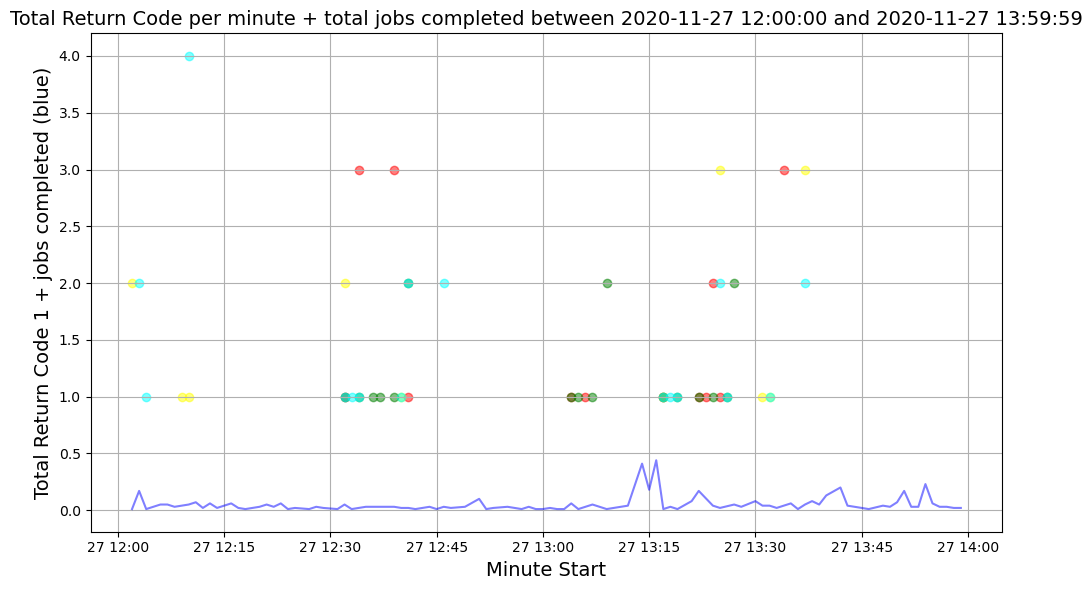

In [79]:
jobs_and_servers_between_dates_9204('2020-11-27 12:00:00', '2020-11-27 13:59:59')

In [77]:
def jobs_and_servers_between_dates(begin_date, end_date):
    jobs_grouped_specified_date_frame = jobs_grouped[jobs_grouped['end_dt_min_start'].between(begin_date, end_date)]
    ce5_grouped_specified_date_frame = ce5_grouped[ce5_grouped['end_dt_min_start'].between(begin_date, end_date)]
    ce6_grouped_specified_date_frame = ce6_grouped[ce6_grouped['end_dt_min_start'].between(begin_date, end_date)]

    plt.figure(figsize=(10, 6))
    plt.plot(ce6_grouped_specified_date_frame['end_dt_min_start'], ce6_grouped_specified_date_frame['total_return_code_1'], color='purple', alpha=.5)
    plt.plot(ce5_grouped_specified_date_frame['end_dt_min_start'], ce5_grouped_specified_date_frame['total_return_code_1'], color='black', alpha=.5)
    plt.plot(jobs_grouped_specified_date_frame['end_dt_min_start'], jobs_grouped_specified_date_frame['total_completed_jobs'], color='orange', alpha=.5)
    plt.title(f'Total Return Code = 1 per minute + total jobs completed between {begin_date} and {end_date}', fontsize=14)
    plt.xlabel('Minute Start', fontsize=12)
    plt.ylabel('Total Return Code 1 + jobs completed (red)', fontsize=12)
    plt.grid(True)
    plt.tight_layout();

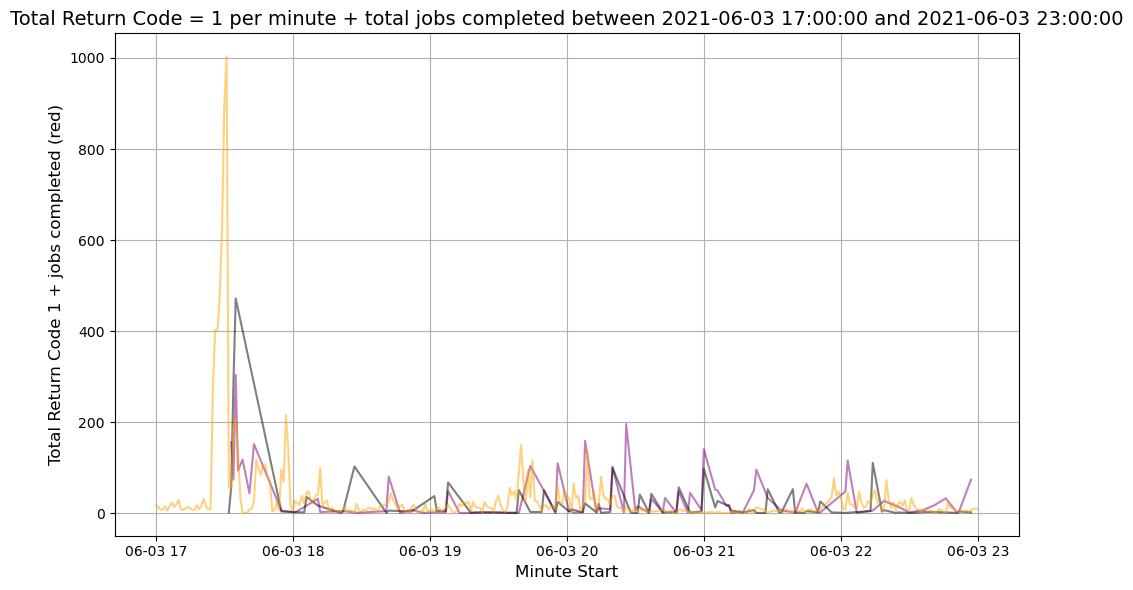

In [51]:
jobs_and_servers_between_dates('2021-06-03 17:00:00', '2021-06-03 23:00:00')

In [52]:
jobs_grouped_11_27_2020 = jobs_grouped[jobs_grouped['end_dt_min_start'].between('2020-11-26', '2020-11-28')]
ce5_grouped_11_27_2020 = ce5_grouped[ce5_grouped['end_dt_min_start'].between('2020-11-26', '2020-11-28')]
ce6_grouped_11_27_2020 = ce6_grouped[ce6_grouped['end_dt_min_start'].between('2020-11-26', '2020-11-28')]

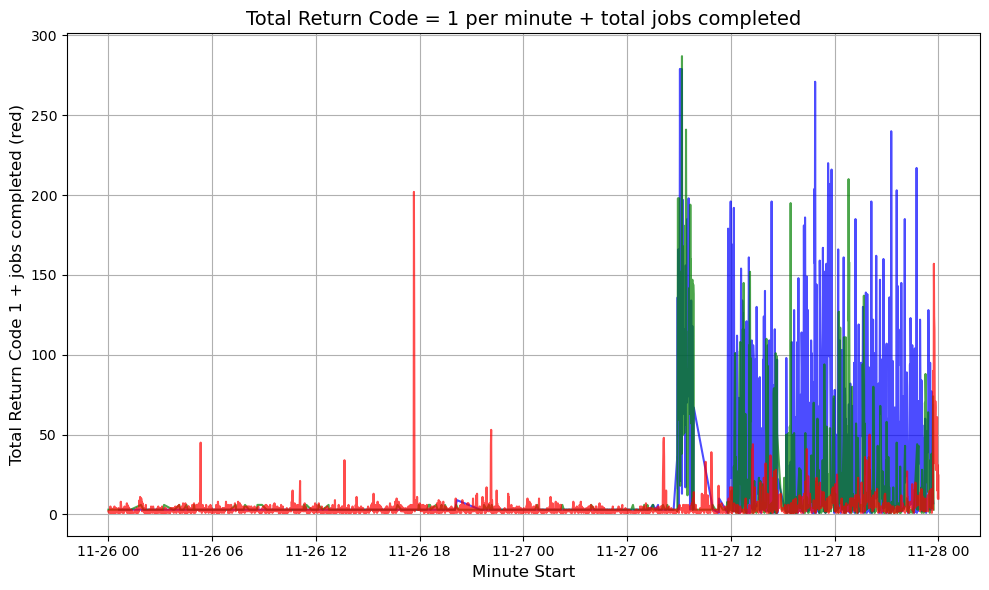

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(ce6_grouped_11_27_2020['end_dt_min_start'], ce6_grouped_11_27_2020['total_return_code_1'], color='blue', alpha=.7)
plt.plot(ce5_grouped_11_27_2020['end_dt_min_start'], ce5_grouped_11_27_2020['total_return_code_1'], color='green', alpha=.7)
plt.plot(jobs_grouped_11_27_2020['end_dt_min_start'], jobs_grouped_11_27_2020['total_completed_jobs'], color='red', alpha=.7)
plt.title('Total Return Code = 1 per minute + total jobs completed', fontsize=14)
plt.xlabel('Minute Start', fontsize=12)
plt.ylabel('Total Return Code 1 + jobs completed (red)', fontsize=12)
plt.grid(True)
plt.tight_layout();

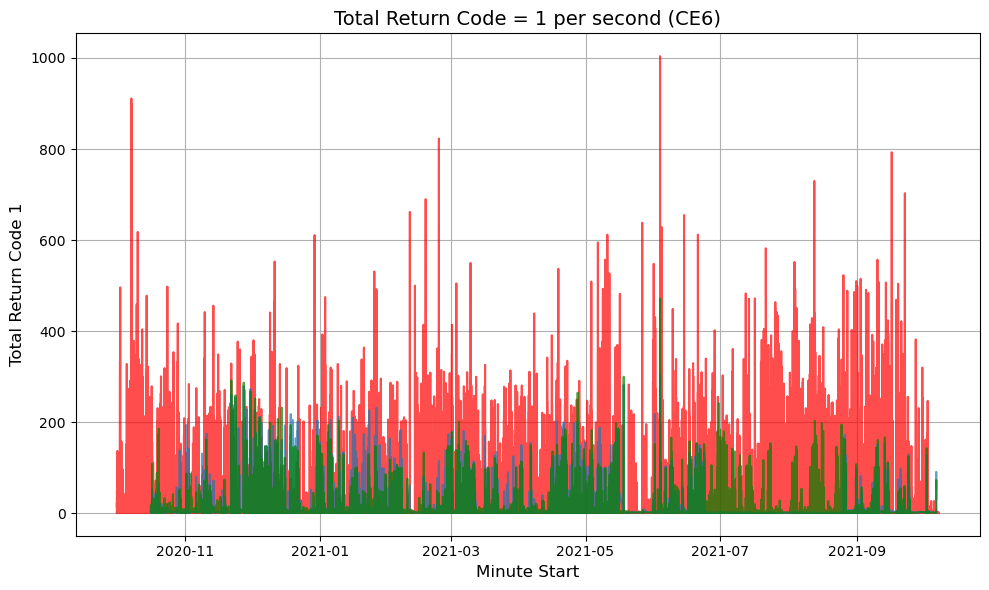

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(jobs_grouped['end_dt_min_start'], jobs_grouped['total_completed_jobs'], color='red', alpha=.7)
plt.plot(ce6_grouped['end_dt_min_start'], ce6_grouped['total_return_code_1'], linestyle='-', alpha=.7)
plt.plot(ce5_grouped['end_dt_min_start'], ce5_grouped['total_return_code_1'], color='green', alpha=.7)
plt.title('Total Return Code = 1 per second (CE6)', fontsize=14)
plt.xlabel('Minute Start', fontsize=12)
plt.ylabel('Total Return Code 1', fontsize=12)
plt.grid(True)
plt.tight_layout();

In [55]:
incomplete_jobs = jobs[(jobs['EXITCODE']!='0:0') | (jobs['STATE']!='COMPLETED')]
incomplete_jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,BEGIN_dt,END_dt
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0,2021-07-31 22:15:00,NaT
18,31418105,NODE_FAIL,2021-08-19T10:09:50,2021-09-17T08:45:10,92160Mn,0,41-16:00:00,28-22:35:20,1,8,cgw-dougherty1,1:0,2021-08-19 10:09:50,2021-09-17 08:45:10
42,31669402,CANCELLED,2021-08-28T10:53:59,2021-09-05T10:53:57,65536Mn,5229.75M,8-00:00:00,7-23:59:58,9,10,production,0:15,2021-08-28 10:53:59,2021-09-05 10:53:57
1023,31798622,CANCELLED,2021-08-31T02:46:09,2021-09-05T02:46:09,40960Mn,1440.95M,5-00:00:00,5-00:00:00,4,4,turing,0:15,2021-08-31 02:46:09,2021-09-05 02:46:09
1029,31798672,CANCELLED,2021-08-31T02:53:48,2021-09-05T02:54:09,40960Mn,1438.46M,5-00:00:00,5-00:00:21,4,4,turing,0:15,2021-08-31 02:53:48,2021-09-05 02:54:09


In [56]:
ce5_9204.dtypes

0                        object
1                        object
2                        object
5                        object
response_time           float64
return_code              object
datetime         datetime64[ns]
dtype: object

In [57]:
ce5_9204['slurm_success'] = ce5_9204['return_code'].str.startswith('0').astype(int)
ce5_9204['server'] = 'ce5'
ce5_9204.shape

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/161908361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce5_9204['slurm_success'] = ce5_9204['return_code'].str.startswith('0').astype(int)
/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/161908361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce5_9204['server'] = 'ce5'


(159847, 9)

In [58]:
ce6_9204['slurm_success'] = ce6_9204['return_code'].str.startswith('0').astype(int)
ce6_9204['server'] = 'ce6'
ce6_9204.shape

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/614475748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce6_9204['slurm_success'] = ce6_9204['return_code'].str.startswith('0').astype(int)
/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_33549/614475748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce6_9204['server'] = 'ce6'


(154862, 9)

In [59]:
#servers_9204 = pd.merge(ce5_9204, ce6_9204, how='outer')
servers_9204 = pd.concat([ce5_9204, ce6_9204])
servers_9204.sample(10)

,0,1,2,5,response_time,return_code,datetime,slurm_success,server
4775609,2021-10-07 19:03:52.797333,user 9204,retry 0,"command ['/usr/bin/sacct', '-j', '32923934', '...",0.106364,0,2021-10-07 19:03:52.797333,1,ce6
3053299,2021-05-29 02:35:54.280523,user 9204,retry 0,"command ['/usr/bin/scontrol', 'show', 'job']",1.423508,0,2021-05-29 02:35:54.280523,1,ce5
3005804,2021-05-18 21:57:43.597493,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.034747,0,2021-05-18 21:57:43.597493,1,ce5
1155476,2020-12-04 00:17:42.051128,user 9204,retry 0,"command ['/usr/bin/sacct', '-j', '26261432', '...",0.099646,0,2020-12-04 00:17:42.051128,1,ce6
912052,2020-11-28 06:07:27.257236,user 9204,retry 0,"command ['/usr/bin/sacct', '-j', '26068803', '...",0.171527,0,2020-11-28 06:07:27.257236,1,ce6
4334256,2021-07-14 00:37:09.919437,user 9204,retry 0,"command ['/usr/bin/sacct', '-j', '30249421', '...",0.839229,0,2021-07-14 00:37:09.919437,1,ce6
3692023,2021-07-12 05:44:38.439446,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",11.122759,0,2021-07-12 05:44:38.439446,1,ce5
383571,2020-11-10 03:35:15.013230,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.040474,0,2020-11-10 03:35:15.013230,1,ce6
3123182,2021-04-07 09:50:45.436195,user 9204,retry 0,"command ['/usr/bin/scontrol', 'show', 'job']",7.845895,0,2021-04-07 09:50:45.436195,1,ce6
2551133,2021-03-02 00:44:25.073990,user 9204,retry 0,"command ['/usr/bin/sacct', '-j', '27668422', '...",0.103023,0,2021-03-02 00:44:25.073990,1,ce6


In [ ]:
return_code_jobs_completed_logit = smf.logit('slurm_success ~ end_dt_min_start + Number_of_Jobs_ThatAreAboutToFinishSuccessfully',
                    data = Merged_df).fit()
# for extended/future studies, we can also look at the additional independent factor of # of jobs user 4209 submitted on SLURM

NameError: name 'Merged_df' is not defined

In [ ]:
#ce6_unresponsive = ce6_test[(ce6_test[5].str.contains('sbatch')) & (ce6_test[4].str.contains('returncode 1'))]
#ce6_responsive = ce6_test[(ce6_test[5].str.contains('sbatch')) & (ce6_test[4].str.contains('returncode 0'))]
#ce6_unresponsive = ce6_unresponsive[ce6_unresponsive['response_time']>=15]

In [ ]:
ce6_unresponsive[1].value_counts()

NameError: name 'ce6_unresponsive' is not defined

In [ ]:
ce6_unresponsive_9204 = ce6_unresponsive[ce6_unresponsive[1].str.contains('user 9204')]
ce6_responsive_9204 = ce6_responsive[ce6_responsive[1].str.contains('user 9204')]

In [ ]:
ce6_unresponsive_9204['response_time'].describe()

count    1485.000000
mean       20.252049
std         1.828402
min        19.027786
25%        20.032605
50%        20.039831
75%        20.045578
max        43.078285
Name: response_time, dtype: float64

In [ ]:
ce6_unresponsive_9204.head(2)

,0,1,2,4,5,response_time,return_code
36913,2020-10-18 06:16:25.392946,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.037672,1
37605,2020-10-18 06:38:44.172473,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.038736,1
